In [ ]:
# this is copied from comp_word2vec_002
# but the comp was set instead of list

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import itertools
import re

import matplotlib.pyplot as plt
import seaborn as sns
import string
import time

In [3]:
from gensim.models import Word2Vec
import gensim

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import accuracy_score

In [3]:
xcf_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/xcf_flavordb_data.pkl')
ars_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/ars_flavordb_data.pkl')
kb_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/kb_flavordb_data.pkl')

In [4]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(11821, 2)
(10623, 2)
(9047, 2)


In [7]:
xcf_data=xcf_data.explode('flavordb_ingrs').reset_index(drop=True)
ars_data=ars_data.explode('flavordb_ingrs').reset_index(drop=True)
kb_data=kb_data.explode('flavordb_ingrs').reset_index(drop=True)

In [8]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(65717, 2)
(85502, 2)
(86423, 2)


In [9]:
# load the ingredients and flavor cmpounds info from flavordb dataset

In [7]:
compound_info=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/propossed_ingr_comp.pkl')
compound_info.shape

(60263, 5)

In [8]:
compound_info.head()

,ingredient_id,ingredient_name,compound_id,compound_name,CAS_number
0,0,egg,182,Dimethyl disulfide,624-92-0
1,0,egg,1095,L-histidine,71-00-1@26062-48-6
2,0,egg,45,Isobutyraldehyde,78-84-2
3,0,egg,127,Styrene,9003-53-6@100-42-5@98444-30-5@68441-35-0@12770...
4,0,egg,510,1-Undecanol,30207-98-8@143819-62-9@112-42-5


In [15]:
# https://github.com/yacheegupta/chemical/blob/master/model.ipynb
# follow the approach from above link.
# there are some compound names could not be dealt with gensim.utils.simple_preprocess
# 1) 1,2,4-Trimethylbenzene, keep the string after '-',
# 2) 99583-29-6, '-'-->'_',
# 3) phenylacetaldehyde, keep it
# all of them lower cases

In [24]:
compounds=set(compound_info['compound_name'].values.tolist())
len(compounds)

1781

In [25]:
def token(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

In [26]:
compound_info['processed_name']=compound_info['compound_name'].apply(lambda x:gensim.utils.simple_preprocess(x))

In [27]:
compound_info.head()

,ingredient_id,ingredient_name,compound_id,compound_name,processed_name
0,0,egg,182,Dimethyl disulfide,"[dimethyl, disulfide]"
1,0,egg,1095,L-histidine,[histidine]
2,0,egg,127,Styrene,[styrene]
3,0,egg,510,1-Undecanol,[undecanol]
4,0,egg,549,4-Methylthiazole,[methylthiazole]


In [28]:
completed_compound_info=compound_info[compound_info['processed_name'].str.len()!=0]
pending_compound_info=compound_info[compound_info['processed_name'].str.len()==0]

In [29]:
print(completed_compound_info.shape)
print(pending_compound_info.shape)

(56153, 5)
(4110, 5)


In [30]:
for index,row in pending_compound_info.iterrows():
    if re.search('\d+-\d+-\d',row['compound_name']):
        pending_compound_info.loc[index,'processed_name']=row['compound_name']
    if re.search(r'\d',row['compound_name'])==None:
        pending_compound_info.loc[index,'processed_name']=row['compound_name']
    if re.search(r'\-\D',row['compound_name']):
        pending_compound_info.loc[index,'processed_name']=row['compound_name'].split('-')[-1]

In [31]:
pending_compound_info['processed_name']=pending_compound_info['processed_name'].str.lower()

In [32]:
pending_compound_info['processed_name']=pending_compound_info['processed_name'].apply(lambda x:[x])

In [33]:
pending_compound_info.head()

,ingredient_id,ingredient_name,compound_id,compound_name,processed_name
56153,0,egg,45,Isobutyraldehyde,[isobutyraldehyde]
56154,0,egg,3,2-Methylbutyraldehyde,[methylbutyraldehyde]
56155,0,egg,655,50-69-1,[50-69-1]
56156,0,egg,435,"2,5-Dimethylpyrazine",[dimethylpyrazine]
56157,0,egg,60,phenylacetaldehyde,[phenylacetaldehyde]


In [34]:
compound_info=pd.concat([completed_compound_info,pending_compound_info],axis=0).reset_index(drop=True)
compound_info.shape

(60263, 5)

In [35]:
compound_info.sort_values('ingredient_id').reset_index(drop=True,inplace=True)

In [36]:
compound_info.head()

,ingredient_id,ingredient_name,compound_id,compound_name,processed_name
0,0,egg,182,Dimethyl disulfide,"[dimethyl, disulfide]"
1,0,egg,1095,L-histidine,[histidine]
2,0,egg,127,Styrene,[styrene]
3,0,egg,510,1-Undecanol,[undecanol]
4,0,egg,549,4-Methylthiazole,[methylthiazole]


In [37]:
completed_compound_info=compound_info[['ingredient_id','ingredient_name','compound_id','compound_name','processed_name']]

In [38]:
completed_compound_info['ingredient_name']=completed_compound_info['ingredient_name'].str.lower()
completed_compound_info['ingredient_name']=completed_compound_info['ingredient_name'].apply(lambda x:re.sub(' ','_',x))
completed_compound_info['ingredient_name']=completed_compound_info['ingredient_name'].apply(lambda x:re.sub('-','_',x))

In [39]:
completed_compound_info['ingredient_name'][completed_compound_info['ingredient_name']=='pepper_c._chinense']='pepper_c_chinense'
completed_compound_info['ingredient_name'][completed_compound_info['ingredient_name']=="jew's_ear"]='jews_ear'

In [40]:
completed_compound_info['processed_name']=[','.join(map(str,comp)) for comp in completed_compound_info['processed_name']]

In [41]:
completed_compound_info['processed_name']=completed_compound_info['processed_name'].apply(lambda x:re.sub(',','_',x))

In [42]:
completed_compound_info=pd.DataFrame(completed_compound_info.groupby('ingredient_name')['processed_name'].apply(set)).reset_index()
completed_compound_info['processed_name']=completed_compound_info['processed_name'].apply(list)
completed_compound_info['processed_name']=completed_compound_info['processed_name'].apply(lambda x:sorted(x))

In [43]:
completed_compound_info.head()

,ingredient_name,processed_name
0,abalone,"[acetone, acid, acrolein, allyl_alcohol, alpha..."
1,abiyuch,"[acetone, acid, acrolein, allyl_alcohol, alpha..."
2,acerola,"[acetone, acid, acrolein, allyl_alcohol, alpha..."
3,achilleas,[eucalyptol]
4,acorn,"[acetone, acid, acrolein, allyl_alcohol, alpha..."


In [16]:
# merge the compound names with the ingredient from each dataset

In [17]:
# xiachufang

In [71]:
xcf_compounds=pd.merge(xcf_data,completed_compound_info,left_on='flavordb_ingrs',right_on='ingredient_name')
xcf_compounds.shape

(65717, 4)

In [72]:
xcf_compound_list=pd.DataFrame(xcf_compounds.groupby('recipe_id')['processed_name'].apply(sum)).reset_index()
xcf_compound_list['processed_name']=xcf_compund_list['processed_name'].apply(lambda x:sorted(x))
xcf_compound_list.shape

(11821, 2)

In [73]:
xcf_compunds.head()

,recipe_id,flavordb_ingrs,ingredient_name,processed_name
0,x_100000002,capsicum,capsicum,"[24168-70-5, 80-71-7, ac_cnw, acetoin, acetone..."
1,x_100000424,capsicum,capsicum,"[24168-70-5, 80-71-7, ac_cnw, acetoin, acetone..."
2,x_100000908,capsicum,capsicum,"[24168-70-5, 80-71-7, ac_cnw, acetoin, acetone..."
3,x_100000943,capsicum,capsicum,"[24168-70-5, 80-71-7, ac_cnw, acetoin, acetone..."
4,x_100002070,capsicum,capsicum,"[24168-70-5, 80-71-7, ac_cnw, acetoin, acetone..."


In [74]:
xcf_compound_list.head()

,recipe_id,processed_name
0,x_100000002,"[1125-21-9, 156420-69-8, 24168-70-5, 24168-70-..."
1,x_100000003,"[betaine, betaine, betaine, betaine, betaine, ..."
2,x_100000175,"[1195-32-0, 3658-77-3, 6753-98-6, ac_cnw, ac_l..."
3,x_100000273,"[23747-48-0, 3658-77-3, acetone, acetone, acet..."
4,x_100000303,"[104-50-7, 104-50-7, 13679-85-1, 23726-92-3, 2..."


In [ ]:
# allrecipes

In [53]:
ars_compunds=pd.merge(ars_data,completed_compound_info,left_on='flavordb_ingrs',right_on='ingredient_name')
ars_compunds.shape

(85502, 4)

In [54]:
ars_compound_list=pd.DataFrame(ars_compunds.groupby('recipe_id')['processed_name'].apply(sum)).reset_index()
ars_compound_list['processed_name']=ars_compound_list['processed_name'].apply(lambda x:sorted(x))
ars_compound_list.shape

(10623, 2)

In [55]:
ars_compound_list=pd.DataFrame(ars_compunds.groupby('recipe_id')['processed_name'].apply(sum)).reset_index()
ars_compound_list['processed_name']=ars_compound_list['processed_name'].apply(lambda x:sorted(x))
ars_compound_list.shape

(10623, 2)

In [56]:
kb_compounds=pd.merge(kb_data,completed_compound_info,left_on='flavordb_ingrs',right_on='ingredient_name')
kb_compounds.shape

(86423, 4)

In [57]:
kb_compound_list=pd.DataFrame(kb_compounds.groupby('recipe_id')['processed_name'].apply(sum)).reset_index()
kb_compound_list['processed_name']=kb_compound_list['processed_name'].apply(lambda x:sorted(x))
kb_compound_list.shape

(9047, 2)

In [58]:
# train the word2vec model on the corpus(compound_info.processed_name)

In [75]:
xcf_compound_list['origin']=0
ars_compound_list['origin']=1
kb_compound_list['origin']=2

In [76]:
all_compound_list=pd.concat([xcf_compound_list,ars_compound_list,kb_compound_list],axis=0).reset_index(drop=True)
all_compound_list.shape

(31491, 3)

In [77]:
all_compound_list['processed_name']=all_compound_list['processed_name'].apply(lambda x:set(x))

In [78]:
all_compound_list['processed_name']=all_compound_list['processed_name'].apply(lambda x:sorted(x))

In [79]:
all_compound_list['processed_name']=all_compound_list['processed_name'].apply(lambda x:list(x))

In [ ]:
# split the train and test set

In [84]:
train_df,test_df,train_y,test_y=train_test_split(all_compound_list['processed_name'],all_compound_list['origin'],test_size=0.3)

In [88]:
train_df.head()

,processed_name
0,"[103-95-7, 24168-70-5, 50-69-1, 5986-55-0, 675..."
1,"[101517-87-7, 104-50-7, 1195-32-0, 13494-07-0,..."
2,"[104-50-7, 13679-85-1, 23726-92-3, 23747-48-0,..."
3,"[1195-32-0, 4674-50-4, 50-69-1, 6753-98-6, ac_..."
4,"[104-50-7, 13679-85-1, 16491-36-4, 23726-92-3,..."


In [87]:
train_df=pd.DataFrame(train_df).reset_index(drop=True)
test_df=pd.DataFrame(test_df).reset_index(drop=True)

In [89]:
print('Num. data in train set:', train_df.shape)
print('Num. data in test set:', test_df.shape)

Num. data in train set: (22043, 1)
Num. data in test set: (9448, 1)


In [90]:
train_sentences=[]
for sentence in train_df['processed_name']:
    train_sentences.append(sentence)

In [91]:
num_features=100     
min_word_count=1  
num_workers=1
downsampling = 1e-3

model=Word2Vec(train_sentences,workers=num_workers,
               vector_size=num_features,min_count=min_word_count,sg=0,sample = downsampling)

In [92]:
def get_w2v_features(sentence,model):
    #model_vocabs=set(model.wv.vocab.keys())
    model_vocabs=set(model.wv.key_to_index.keys())
    featureVec = np.zeros(model.vector_size, dtype="float32")
    
    nwords=0
    for word in sentence:
        if word in model_vocabs:
            #featureVec=np.add(featureVec,model[word])
            featureVec=np.add(featureVec,model.wv[word])
            nwords+=1
        else:
            featureVec=featureVec
    if nwords > 0:
        #print(nwords)
        featureVec=np.divide(featureVec,nwords)
    return featureVec

In [93]:
train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,model),train_df['processed_name']))
test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,model),test_df['processed_name']))

In [94]:
train_X=np.array(list(map(np.array,train_df['w2v_features'])))
test_X=np.array(list(map(np.array,test_df['w2v_features'])))

In [95]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = GaussianNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [96]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'penalty':['l1','l2'],
                    'solver':['newton-cg','lbfgs','sag','saga']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    log.fit(train_X,train_y)
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [97]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    rf.fit(train_X,train_y)
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [98]:
nb_ypred=NB_pipeline(train_X,test_X,train_y,test_y)

Mean Accuracy: 0.35 (+/- 0.01)
Accuracy on test set: 0.35


In [99]:
log_ypred=log_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn

Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
Best estimatro: LogisticRegression(C=10, random_state=9527, solver='newton-cg')
Best score: 0.6645644797660617
accuracy score:  0.6619390347163421


In [100]:
rf_ypred=rf_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}
Best estimatro: RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)
Best score: 0.6903778424679103
accuracy score:  0.6969729043183742


In [ ]:
# learning curve

In [102]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

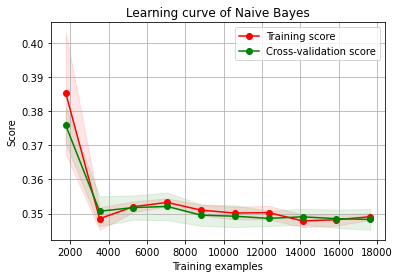

In [104]:
estimator=GaussianNB()
plot_cv_learning_curve(estimator, 'Learning curve of Naive Bayes', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_w2v_nb_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_w2v_nb_lc.png',dpi=300, bbox_inches='tight')

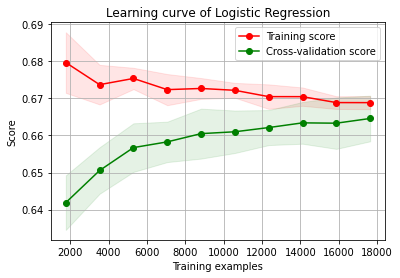

In [105]:
estimator=LogisticRegression(C=10, random_state=9527, solver='newton-cg')
plot_cv_learning_curve(estimator, 'Learning curve of Logistic Regression', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_w2v_log_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_w2v_log_lc.png',dpi=300, bbox_inches='tight')

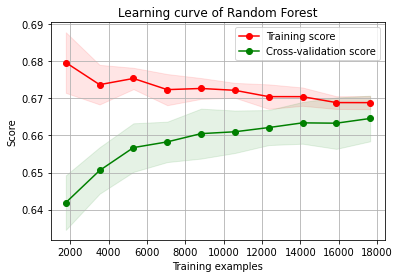

In [106]:
estimator=LogisticRegression(C=10, random_state=9527, solver='newton-cg')
plot_cv_learning_curve(estimator, 'Learning curve of Random Forest', train_X, train_y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_w2v_rf_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_w2v_rf_lc.png',dpi=300, bbox_inches='tight')

In [ ]:
# confusion matrix

In [107]:
def plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.tight_layout()

In [108]:
rf_cm=confusion_matrix(rf_ypred,test_y)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.76 0.13 0.1 ]
 [0.1  0.64 0.26]
 [0.09 0.25 0.66]]


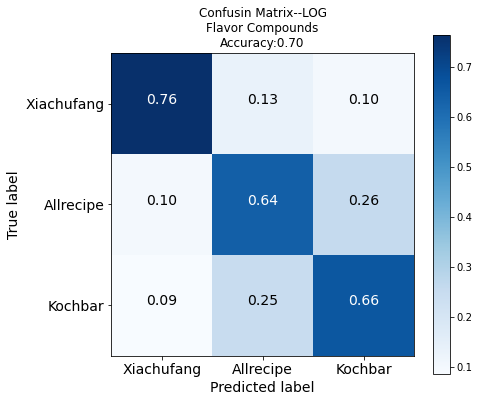

In [110]:
plt.figure(figsize=(7,6))
plot_confusion_matrix(rf_cm,normalize=True,classes=['Xiachufang','Allrecipe','Kochbar'],
                      title='Confusin Matrix--LOG\nFlavor Compounds\nAccuracy:{0:.2f}'.format(accuracy_score(test_y,rf_ypred)))
plt.savefig('fig/pdf/comp_w2v_rf_cm.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/comp_w2v_rf_cm.png',dpi=300,bbox_inches='tight')